In [356]:
# Quelle: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
# pip install torchtext
# pip install spacy
# python -m spacy download de
# pip install torch


import pandas as pd

df=pd.read_csv("Amazon-Deutsch-Dataset.csv")
df.head()


,Unnamed: 0,web-scraper-order,web-scraper-start-url,author,title,date,content,rating,next,next-href,Unnamed: 9
0,0,1582056286-2631,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,MHS,Das Beste iPhone aller Zeiten,5. Januar 2020,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,"5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
1,1,1582056184-2351,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Amazon Customer,besser als beim hersteller,21. September 2019,"gestern bestellt, heute geliefert. besser geht...","5,0 von 5 Sternen",NaN,NaN,NaN
2,2,1582056243-2561,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Joko Müller,Gutes Handy mit kleinen Schwächen,27. Oktober 2019,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...","4,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
3,3,1582056201-2410,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Davorko,Ein sehr edles Stück dieses IPHONE 11,2. Januar 2020,Amazon hat wieder super-schnell geliefert. Dan...,"5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN
4,4,1582056246-2585,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,Chiara Natalia Sozzi,Super,18. Oktober 2019,"Viel früher angekommen als angegeben, tolles H...","5,0 von 5 Sternen",Weiter→,https://www.amazon.de/Apple-iPhone-11-128-GB-S...,NaN


In [357]:
len(df)

3413

In [358]:
# uns interessiert erstmal nur content und rating als Zahl
df = df[["content", "rating"]]
df.head()

,content,rating
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,"5,0 von 5 Sternen"
1,"gestern bestellt, heute geliefert. besser geht...","5,0 von 5 Sternen"
2,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...","4,0 von 5 Sternen"
3,Amazon hat wieder super-schnell geliefert. Dan...,"5,0 von 5 Sternen"
4,"Viel früher angekommen als angegeben, tolles H...","5,0 von 5 Sternen"


In [359]:
df.rating= df.rating.str[0]
df.head()

,content,rating
0,Ich bin sehr zufrieden mit dem iPhone 11. Der ...,5
1,"gestern bestellt, heute geliefert. besser geht...",5
2,"Ich mach es mal kurz:\nGut: Optik, Verarbeitun...",4
3,Amazon hat wieder super-schnell geliefert. Dan...,5
4,"Viel früher angekommen als angegeben, tolles H...",5


In [360]:
df.dropna(inplace=True)

In [361]:
def convert_rating(x):
    if int(x)<=3:
        return "0"
    else:
        return "1"
    
df.rating = df.rating.apply(convert_rating)

<Axes: >

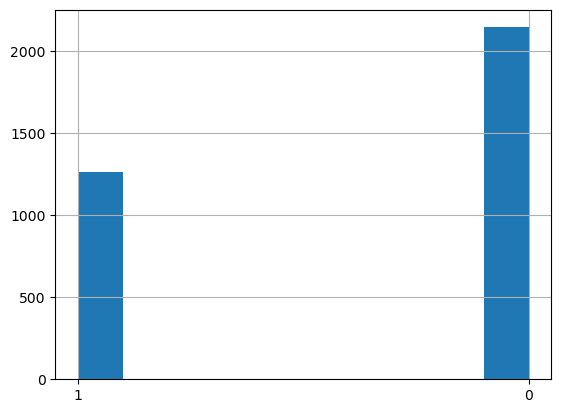

In [362]:
df.rating.hist()

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3409 entries, 0 to 3412
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  3409 non-null   object
 1   rating   3409 non-null   object
dtypes: object(2)
memory usage: 79.9+ KB


In [364]:
# remove rows with missing values
df = df.dropna()

In [365]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [366]:
tokenizer = get_tokenizer('spacy', language='de_core_news_sm')

# create iterator from tokenized df
def df_iterator_content(df):
    for _, row in df.iterrows():
        yield tokenizer(row['content'])


In [367]:
vocab = build_vocab_from_iterator(df_iterator_content(df))

3409lines [00:01, 3342.85lines/s]


In [368]:
import torchtext

vocab=torchtext.vocab.Vocab(vocab.freqs, specials=['<unk>'], min_freq=5)

In [369]:
len(vocab)

4163

In [370]:
def get_vocab_idx(word_list):
    return [vocab[token] for token in word_list]
            
get_vocab_idx(["Hallo", "Amazon", "läuft", "bei", "sie", "!"])

[1029, 179, 357, 33, 69, 18]

In [371]:
def text_pipeline(x):                           # die benutzen wir später um Text in Vektoren zu übersetzen
    return get_vocab_idx(tokenizer(x))
    

label_pipeline = lambda x: int(x)           # (andere Schreibweise) die ratings liegen als Text vor und gehen von 1 bis 5. Daher -1

In [372]:
tokenizer('Die letzte Bestellung, war fehlerhaft')

['Die', 'letzte', 'Bestellung', ',', 'war', 'fehlerhaft']

In [373]:
text_pipeline('Die letzte Bestellung, war fehlerhaft') # Beispiel


[32, 1131, 1026, 2, 36, 0]

In [374]:
text_pipeline('Hallo Amazon, läuft bei dir! Bzw. bzw. usw. ...') # Beispiel


[1029, 179, 2, 357, 33, 0, 18, 0, 1, 385, 648, 86]

In [375]:
from torch.utils.data import DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    '''
    Extrahiert aus einer Batch von Text die Labels und die Texte und übersetzt diese in Vektoren(Zahlen-Arrays) mittels text_pipeline und label_pipeline
    '''
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

# check if collate_batch works
collate_batch([("Das neue IPhone ist wirklich toll!!", "5"), ("FritzBox 7830 ist schon ganz nett, aber geht besser", "3")])

(tensor([5, 3]),
 tensor([  28,  212,  472,    6,  122,  656,   18,   18,  778,    0,    6,   61,
          145, 2043,    2,   26,  146,  129]),
 tensor([0, 8]))

In [376]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)  # sparse means: 
        self.fc = nn.Linear(embed_dim, 30)
        self.dropout = nn.Dropout(0.5)
        self.fc2= nn.Linear(30, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        out=self.fc(embedded)
        out=self.dropout(out)
        # relu
        out=nn.ReLU()(out)
        return self.fc2(out)

In [377]:
num_class = df["rating"].nunique()
vocab_size = len(vocab)
emsize = 512
print(num_class, vocab_size, emsize)

2 4163 512


In [378]:
import time

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [379]:
from torch.utils.data.dataset import random_split

train_dataset=df[['content', 'rating']].values;

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

-----------------------------------------------------------
| end of epoch   1 | time:  1.34s | train accuracy    0.751 | valid accuracy    0.719 | lr: 1.00
-----------------------------------------------------------
| end of epoch   2 | time:  1.29s | train accuracy    0.788 | valid accuracy    0.766 | lr: 1.00
-----------------------------------------------------------
| end of epoch   3 | time:  1.27s | train accuracy    0.821 | valid accuracy    0.778 | lr: 1.00
-----------------------------------------------------------
| end of epoch   4 | time:  1.22s | train accuracy    0.838 | valid accuracy    0.801 | lr: 0.90
-----------------------------------------------------------
| end of epoch   5 | time:  1.18s | train accuracy    0.852 | valid accuracy    0.807 | lr: 0.90
-----------------------------------------------------------
| end of epoch   6 | time:  1.19s | train accuracy    0.884 | valid accuracy    0.819 | lr: 0.90
----------------------------------------------------------

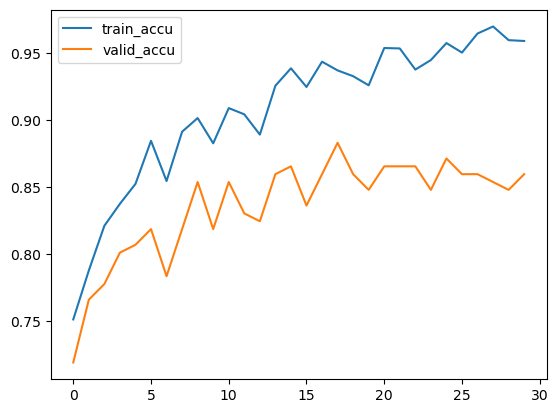

In [380]:
# Hyperparameters
EPOCHS = 30 # epoch
LR = 1  # learning rate
BATCH_SIZE = 64 # batch size for training

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,collate_fn=collate_batch)

loss_func = torch.nn.CrossEntropyLoss()
#
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
#optimizer=torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3.0, gamma=0.9)   # every 3 epochs, LR is multiplied by 0.7
total_accu = None

train_accus=[]
valid_accus=[]


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model.train()
    total_acc, total_count = 0, 0

    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = loss_func(predicted_label, label)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    accu_train = evaluate(model, train_dataloader)
    accu_valid = evaluate(model, valid_dataloader)
    train_accus.append(accu_train)
    valid_accus.append(accu_valid)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | valid accuracy {:8.3f} | lr: {:1.2f}'.format(
                                epoch,
                                time.time() - epoch_start_time,
                                accu_train, 
                                accu_valid, 
                                scheduler.get_last_lr()[0]))

    scheduler.step() # learning rate scheduler after each epoch



import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [381]:
# how much valid accuracy do we get in a new untrained model?
new_model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
evaluate(new_model, valid_dataloader)


0.6257309941520468